## Siamese Network 

Credit: PyImage Search's by Adrain Rosebock  https://www.pyimagesearch.com/2020/11/23/building-image-pairs-for-siamese-networks-with-python/ 

Siamese networks are a special type of network with contain two or more identical subnetworks. These subnetworks have the same architecture parameters and weights and parameter updates are mirrored across both networks. 

They are very relevant in verification, identification and recognition tasks, especially in facial recognition and signature verification.

In [ ]:
pip install tensorflow==2.3

In [ ]:
pip install imutils

In [16]:
# Import the necessary libraries

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K
from imutils import build_montages
from imutils.paths import list_images
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

### Part 1: Building Image Pairs for Siamese Networks with Python

First we build an image pair generator. This would accept a set of input images and labels and then generate positive and negative pairs. The MNIST digit dataset would be the sample dataset.

In [2]:
# Define generator function

def generate_pairs(images, labels):
    
    # Initialize empty lists to hold image 
    pair_images = []
    pair_labels = []
    
    # Build a list containing lists of the indices of unique labels
    num_classes = len(np.unique(labels))
    indexes = [np.where(labels == i)[0] for i in range(0, num_classes)]
    
    # Generate pairs and corresponding labels
    for imgA_ind in range(len(images)):
        
        curr_img = images[imgA_ind]
        label = labels[imgA_ind]
        
        # Get a positive image i.e with the same label 
        imgB_ind = np.random.choice(indexes[label])
        pos_img = images[imgB_ind]
        
        pair_images.append([curr_img, pos_img])
        pair_labels.append(1)
        
        # Get a negative image i.e with different label
        # First we get the indices of labels not the same as the label above
        
        neg_indexes = np.where(labels != label)[0]
        neg_img = images[np.random.choice(neg_indexes)]
        
        pair_images.append([curr_img, neg_img])
        pair_labels.append(0)
        
    
    return (np.array(pair_images), np.array(pair_labels))
        

In [3]:
# Load the MNIST dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Build pairs for train and test data
(train_pairs, train_labels) = generate_pairs(train_X, train_y)
(test_pairs, test_labels) = generate_pairs(test_X, test_y)


In [4]:
# Construct a Montage to visualize image pairs

# Initialize list to be used for montages
images = []

for i in np.random.choice(np.arange(0, len(train_pairs)), size=(49,)):
    
    image_A = train_pairs[i][0]
    image_B = train_pairs[i][1]
    label = train_labels[i]
    
    output = np.zeros((36, 60), dtype='uint8')
    pair = np.hstack([image_A, image_B])
    
    output[4:32, 0:56] = pair
    
    text = 'neg' if label==0 else 'pos'
    color = (255, 0, 0) if label==0 else (0, 255, 0)
    
    visual = cv2.merge([output] * 3)
    visual = cv2.resize(visual, (96, 51), interpolation=cv2.INTER_LINEAR)
    cv2.putText(visual, text, (2, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)
    
    images.append(visual)
    
##### Build the montage
montage = build_montages(images, (96, 51), (7, 7))[0]

In [ ]:

# Show the output image pairs
cv2.imshow('Siamese Image Pairs', montage)
cv2.waitKey(0)

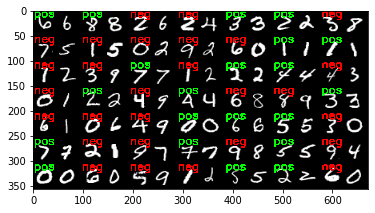

In [5]:
plt.imshow(montage)





### Part 2: Training Siamese Networks with Keras, TensorFlow and Deep Learning

In this part, the Siamese network is trained using Keras, Tensorflow and Deep learning. The network will then be able to predict if two images presented to it belong in the same class using a confidence score.

The loss function that would be used is the Binary cross-entropy function. Other loss functions include the Triplet loss and Contrastive loss. These two make use if image triplets.

In [13]:
# Model Configuration

input_shape = (28, 28, 1)

batch_size = 64
epochs = 20

# Define output paths
output_dir = 'output'

# Since the siamese model requires a lambda layer, we would be using a SavedModel format
model_path = os.path.sep.join([output_dir, 'siamese_model'])
plot_path = os.path.sep.join([output_dir, 'plot.png'])


In [7]:
# Build a function to construct component of sister models

def build_siamese_model(input_shape, embedding_dim=48):
    
    inputs = Input(input_shape)
    
    # Define first Conv block
    x = Conv2D(64, (2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    
    # Define second Conv block
    x = Conv2D(64, (2,2), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    # Final outputs
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(embedding_dim)(x)
    
    # Build model
    model = Model(inputs, outputs)
    
    return model

NB: In order to construct our siamese network architecture, we need to be able to compute the Euclidean distance between the sister network outputs inside the siamese architecture itself.

Hence to accomplish this task, we would use a custom Lambda layer. A Lambda layer is used to embed Keras/Tensorflow functions inside of a model. Therefore, instead of using numpy/scipy to calculate the Euclidean distance, we would use a keras function. 

In [8]:
# Next we construct a function for the Euclidean distance Lambda layer

def euclidean_dist(vectors):
    """Computes the Euclidean
    distance between two vectors.
    
    Args:
        vectors: Tuple of 2 vectors"""
    
    (feats_a, feats_b) = vectors
    
    # Get sum of squared distances between vectors
    sum_squared = K.sum(K.square(feats_a - feats_b), axis=1,
                       keepdims=True)
    
    # Get the Euclidean distance between the vectors
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [9]:
# Create a function to plot training history

def plot_history(H, plot_path):
    
    """
    Plot training history.
    Args:
        H: Training history
        plot_path: Path to store plots"""
    
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(H.history['loss'], label='train_loss')
    plt.plot(H.history['val_loss'], label='val_loss')
    plt.plot(H.history['accuracy'], label='train_acc')
    plt.plot(H.history['val_accuracy'], label='val_acc')
    
    plt.title('Training Loss and Accuracy')
    
    plt.xlabel('Epoch #')
    plt.ylabel('Loss/Accuracy')
    plt.legend(loc='lower left')
    plt.savefig(plot_path)

Then we go ahead to process the images and train the model.

In [10]:
# Scale image pixels to range 0, 1

train_X = train_X / 255.0
test_X = test_X / 255.0


# Add a channel dimension to the images
train_X = np.expand_dims(train_X, axis=-1)
test_X = np.expand_dims(test_X, axis=-1)

# Prepare the positive and negative pairs
(train_pairs, train_labels) = generate_pairs(train_X, train_y)
(test_pairs, test_labels) = generate_pairs(test_X, test_y)

In [11]:
# Then we configure the Siamese network

img_a = Input(shape=input_shape)
img_b = Input(shape=input_shape)

# Even though there are 2 sister networks, we implement them as a single instance.
# This is because they have the same architecture and parameters. So they should have the
# same weights.

feature_extractor = build_siamese_model(input_shape)
feats_a = feature_extractor(img_a)
feats_b = feature_extractor(img_b)


# Then we construct the Siamese network
distance = Lambda(euclidean_dist)([feats_a, feats_b])
outputs = Dense(1, activation='sigmoid')(distance)
model = Model(inputs=[img_a, img_b], outputs=outputs)

In [14]:
# We train the model

model.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=['accuracy'])

history = model.fit([train_pairs[:, 0], train_pairs[:,1]],
                   train_labels[:],
                   validation_data=([test_pairs[:,0], test_pairs[:,1]], test_labels[:]),
                   batch_size=batch_size,
                   epochs=epochs)


Epoch 1/20
1875/1875 [==============================] - 110s 59ms/step - loss: 0.6224 - accuracy: 0.6494 - val_loss: 0.5856 - val_accuracy: 0.6980
Epoch 2/20
1875/1875 [==============================] - 112s 60ms/step - loss: 0.5750 - accuracy: 0.7012 - val_loss: 0.5159 - val_accuracy: 0.7542
Epoch 3/20
1875/1875 [==============================] - 113s 60ms/step - loss: 0.5331 - accuracy: 0.7361 - val_loss: 0.4783 - val_accuracy: 0.7794
Epoch 4/20
1875/1875 [==============================] - 108s 58ms/step - loss: 0.5073 - accuracy: 0.7523 - val_loss: 0.4510 - val_accuracy: 0.7951
Epoch 5/20
1875/1875 [==============================] - 111s 59ms/step - loss: 0.4843 - accuracy: 0.7689 - val_loss: 0.4241 - val_accuracy: 0.8107
Epoch 6/20
1875/1875 [==============================] - 119s 63ms/step - loss: 0.4663 - accuracy: 0.7790 - val_loss: 0.4095 - val_accuracy: 0.8130
Epoch 7/20
1875/1875 [==============================] - 114s 61ms/step - loss: 0.4523 - accuracy: 0.7873 - val_loss: 0

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: output/siamese_model/assets


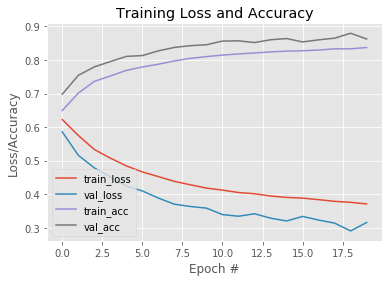

In [15]:
model.save(model_path)
plot_history(history, plot_path)

### Part 3: Comparing images for similarity using siamese networks, Keras, and TensorFlow

Finally, we compare two images for similarity using the trained model. The prediction is done using the final layer of the Siamese network i.e. the Sigmoid activation function.

In [17]:
# First we get the test images and pair them randomly
#   to give 10 pairs
test_dir = 'examples'
test_imgpaths = list(list_images(test_dir))

np.random.seed(42)
test_pairs = np.random.choice(test_imgpaths, size=(15, 2))

In [18]:
# We load the trained model
traind_model = load_model(model_path)
traind_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 48)           19888       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           functional_1[0][0]    

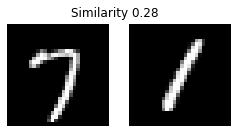

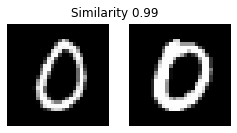

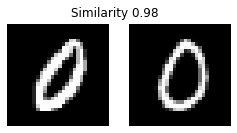

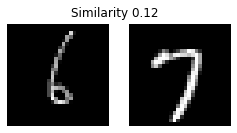

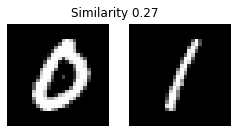

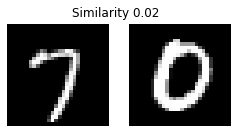

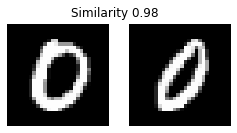

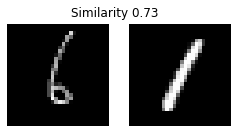

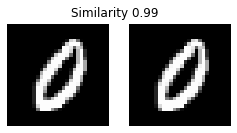

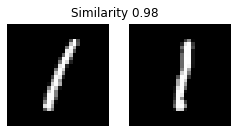

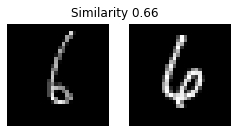

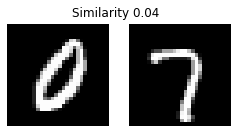

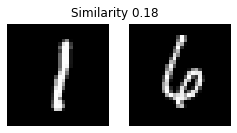

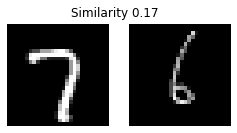

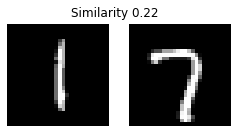

In [29]:
# Then we process the images for prediction

for i, pairs in enumerate(test_pairs):
    
    img_a = cv2.imread(pairs[0], 0)
    img_b = cv2.imread(pairs[1], 0)
    
    # Make copies of the images
    org_a = img_a.copy()
    org_b = img_b.copy()
    
    # Add a channel dimension to the images
    img_a = np.expand_dims(img_a, axis=-1)
    img_b = np.expand_dims(img_b, axis=-1)
    
    # Add a batch dimension to the images
    img_a = np.expand_dims(img_a, axis=0)
    img_b = np.expand_dims(img_b, axis=0)
    
    # Scale pixel values
    img_a = img_a / 255.0
    img_b = img_b / 255.0

    # Predict and compare
    preds = traind_model.predict([img_a, img_b])
    conf = preds[0][0]
    
    # Show prediction
    fig = plt.figure(f"Pair {i + 1}", figsize=(4, 2))
    plt.suptitle("Similarity {:.2f}".format(conf))
    
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(org_a, cmap=plt.cm.gray)
    plt.axis('off')
    
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(org_b, cmap=plt.cm.gray)
    plt.axis('off')
    
    plt.show()
    

From the predictions above, we can see the performance is good but with some errors. Hence the model can be trained to improve performance.

And there we have it, our first Siamese model :D